In [2]:
library(knitr)
library(sqldf)
library(ggplot2)
library(mongolite)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(tidyr)
library(jsonlite)
library(lubridate)
library(gridExtra)
library(GGally)
library(scales)
library(memisc)
 library(sp)
library(rgeos)
library(rgdal)
library(maptools)
library(RColorBrewer)
library(maps)
library(grid)
library(cluster)
library(StatMatch)
library(fastcluster)
library(factoextra)
library(FactoMineR)
library(stringr)
library(googleVis)
library(RMySQL)
library(data.table)
library(dbplyr)
library(DBI)
library(httr)
library(scanstatistics)
library(purrr)
library(magrittr)
library(rsatscan)
library(missMDA)
library(randomForest)
library(caret)
library(spdep)
library(geosphere)
library(tidytext)
library(randomForestExplainer)
#.libPaths(c(file.path(Sys.getenv('SPARK_HOME'), 'R', 'lib'), .libPaths())

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite

Attaching package: 'dplyr'

The following object is masked from 'package:gridExtra':

    combine

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date


Attaching package: 'GGally'

The following object is masked from 'package:dplyr':

    nasa

Loading required package: lattice
Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select


Attaching package: 'memisc'

The following object is masked from 'package:scales':

    percent

The following object is masked from 'package:lubridate':

    is.interval

The following objects are masked from 'package:dplyr':

    collect, recode, rename, syms

The following objec

In [31]:
plot.format <- theme(axis.text = element_text(size = 12), legend.text = element_text(size = 12), legend.title = element_text(size = 12), axis.title = element_text(size = 14), plot.title = element_text(size = 14))

In [1]:
features <- read.csv("../STSS/Files/Features/features2dc_nodup.csv")

In [32]:
summary(features)

      Code               State         State_id                  City     
 TX     : 376   Texas       : 376   Min.   : 1.00   Marion city    :  10  
 CA     : 366   California  : 366   1st Qu.:17.00   Lancaster city :   9  
 IL     : 340   Illinois    : 340   Median :29.00   Auburn city    :   8  
 OH     : 251   Ohio        : 251   Mean   :29.03   Clinton city   :   8  
 PA     : 246   Pennsylvania: 246   3rd Qu.:42.00   Greenville city:   8  
 MO     : 209   Missouri    : 209   Max.   :56.00   Jackson city   :   8  
 (Other):3431   (Other)     :3431                   (Other)        :5168  
       City2            City3             Place_type  
 Clinton  :  12   Clinton  :  12   borough     : 290  
 Jackson  :  12   Jackson  :  12   city        :3782  
 Madison  :  12   Madison  :  12   city/town   :   2  
 Marion   :  12   Marion   :  12   municipality:   4  
 Lancaster:  10   Lancaster:  10   town        : 611  
 Franklin :   9   Franklin :   9   village     : 530  
 (Other)  :5152

In [23]:
nrow(features)

[1] 5224

In [ ]:
colnames()

###### Replace any missing values with medians

In [5]:
median.vals <- features %>% group_by(state) %>%
                    summarise(med_urban = median(urban, na.rm = TRUE),
                              med_rural = median(rural, na.rm = TRUE),
                              med_employ_over16 = median(employ_pop_over16, na.rm = TRUE)) %>%
                as.data.frame()

In [6]:
features <- features %>% group_by(state, add = FALSE) %>%
            mutate(urban = ifelse(is.na(urban), median.vals$med_urban, urban),
                  rural = ifelse(is.na(rural), median.vals$med_rural, rural),
                  employ_pop_over16 = ifelse(is.na(employ_pop_over16), 
                                             median.vals$med_employ_over16, 
                                       employ_pop_over16)) %>%
            as.data.frame()

write.csv(features, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Features_Demo\\features2dc.csv", 
         row.names = FALSE)

In [9]:
features2 <-features[c("totalpopulation", "per_male", "medianage", 
                           "per_urban", "mean_income_per_capita",
                          "house_median_income", "per_english_other",
                          
                         "per_white", "per_employ_over16", "lon", 
                         "lat", "count", "state")]

In [7]:
cor.test(features$white_population, features$black_population)


	Pearson's product-moment correlation

data:  features$white_population and features$black_population
t = 100.05, df = 5217, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8013011 0.8199003
sample estimates:
      cor 
0.8108052 


In [42]:
summary(features)

      Code               State         State_id                  City     
 TX     : 376   Texas       : 376   Min.   : 1.00   Marion city    :  10  
 CA     : 366   California  : 366   1st Qu.:17.00   Lancaster city :   9  
 IL     : 342   Illinois    : 342   Median :29.00   Auburn city    :   8  
 OH     : 252   Ohio        : 252   Mean   :29.04   Clinton city   :   8  
 PA     : 246   Pennsylvania: 246   3rd Qu.:42.00   Greenville city:   8  
 MO     : 209   Missouri    : 209   Max.   :56.00   Jackson city   :   8  
 (Other):3433   (Other)     :3433                   (Other)        :5173  
       City2            City3             Place_type  
 Clinton  :  12   Clinton  :  12   borough     : 290  
 Jackson  :  12   Jackson  :  12   city        :3782  
 Madison  :  12   Madison  :  12   city/town   :   2  
 Marion   :  12   Marion   :  12   municipality:   4  
 Lancaster:  10   Lancaster:  10   town        : 611  
 Franklin :   9   Franklin :   9   village     : 535  
 (Other)  :5157

In [ ]:
### Nonlinear regression using randomForest- variable importance

In [21]:
features.num <- scale(features[c("totalpopulation",
                                "per_male", "medianage", 
                           "per_urban", "mean_income_per_capita", 
                          "house_median_income", "per_english_other",                        
                         "per_white", "per_employ_over16", "lon", 
                         "lat", "count")])

In [ ]:
### Find best value for number of trees - ntree

In [6]:
random_varImp <- list()

set.seed(20190104)
n <- c(100, 500, seq(1000, 5000, 1000))
for (i in n)
random_varImp <- randomForest(count_rate ~ ., data = features.num, importance = TRUE, 
             keep.forest = TRUE, ntree = i, nPerm = 5)

In [22]:
set.seed(20190104)
random_varImp <- randomForest(count ~ ., data = features.num, importance = TRUE, 
             keep.forest = TRUE, ntree = 1000, nPerm = 10)

In [23]:
random_varImp


Call:
 randomForest(formula = count ~ ., data = features.num, importance = TRUE,      keep.forest = TRUE, ntree = 1000, nPerm = 10) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 3

          Mean of squared residuals: 0.5918452
                    % Var explained: 40.8

save(feature_importance, file = "feature_importance.rda")
load("feature_importance.rda")

In [26]:
features_varimp <- varImp(random_varImp, sort = TRUE, scale = TRUE)

In [27]:
features_varimp$Variables <- rownames(features_varimp)
features_varimp %>% dplyr::select(Variables, Overall) %>% arrange(desc(Overall))

Variables,Overall
totalpopulation,18.3820768
house_median_income,7.1816674
mean_income_per_capita,7.0234404
per_english_other,7.0130345
per_male,5.1987608
medianage,4.7483906
lon,4.5289645
per_white,3.2200727
lat,2.7841334
per_employ_over16,-0.8965038


In [75]:
Check without totalpop as correlation with count is high. That is no totalpop and pop for % values

ERROR: Error in parse(text = x, srcfile = src): <text>:1:7: unexpected symbol
1: Check without
          ^


In [28]:
features_varimp <- transform(features_varimp, Variables = reorder(Variables, Overall))

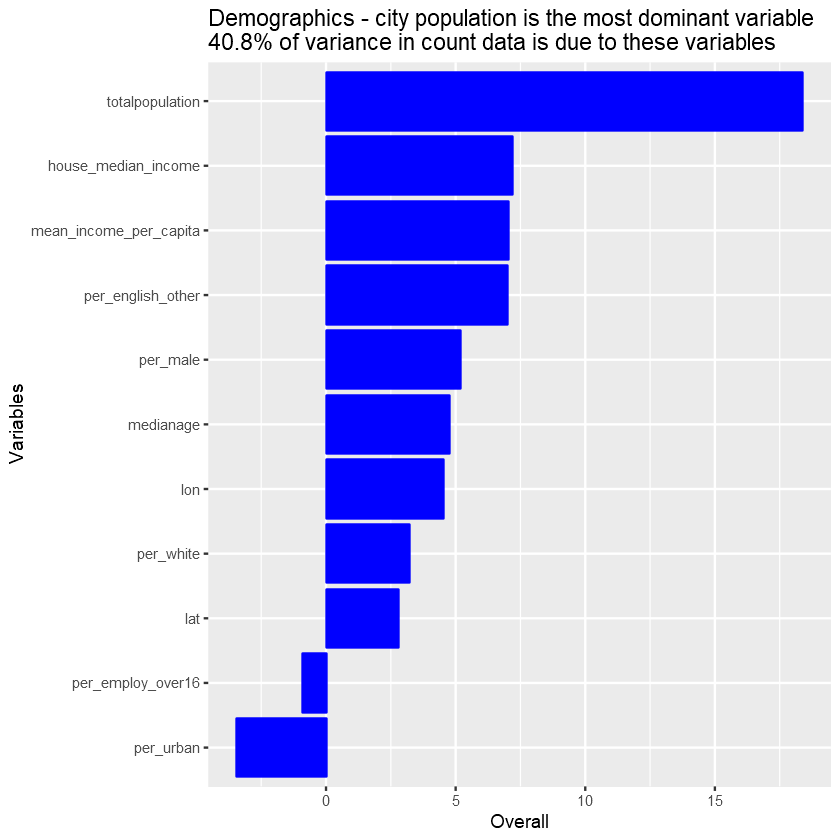

In [30]:
ggplot(aes(x = Variables, y = Overall), data = features_varimp) + 
    geom_col(color = "blue", fill = "blue") +
    coord_flip() +
    labs(title = "Demographics - city population is the most dominant variable\n40.8% of variance in count data is due to these variables", 
         xlab = "% importance") 


In [ ]:
Variance in the output variable count due to the predictors is 40.8%. 